# Heart Failure Prediction: 데이터 분석 및 생존율 예측

## 1. 분석 개요
- **목표**: 심부전증 환자의 임상 기록 데이터를 분석하여 사망 위험 요인을 파악하고 생존 여부를 예측하는 모델을 구축합니다.
- **데이터셋**: Heart Failure Clinical Records Dataset (300명 환자, 13개 Feature)
- **방법론**: OSEMN (Obtain, Scrub, Explore, Model, Interpret) 프로세스를 따릅니다.

## 2. 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# 시각화 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.family'] = 'AppleGothic'  # Mac용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False

## 3. Obtain & Scrub: 데이터 적재 및 품질 검증

데이터를 로드하고 결측치, 이상치, 데이터 타입을 확인합니다.

In [2]:
# 데이터 로드
df = pd.read_csv('../data/heart_failure_clinical_records_dataset.csv')

# 데이터 구조 확인
print("데이터 크기:", df.shape)
display(df.head())

데이터 크기: (299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
# 데이터 타입 및 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [4]:
# 기초 통계량 확인
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [5]:
# 결측치 재확인
missing_values = df.isnull().sum()
print("결측치 개수:\n", missing_values[missing_values > 0])

# 데이터 품질 검증 (Logical Checks)
# 1. 나이가 음수이거나 비상식적인 값인지 확인
assert (df['age'] > 0).all(), "나이에 0 이하의 값이 있습니다."
# 2. 박출계수(ejection_fraction)가 0~100 사이인지 확인
assert (df['ejection_fraction'] >= 0).all() and (df['ejection_fraction'] <= 100).all(), "박출계수 범위 오류"

print("\n✅ 데이터 품질 검증 완료: 결측치 없음, 논리적 오류 없음")

결측치 개수:
 Series([], dtype: int64)

✅ 데이터 품질 검증 완료: 결측치 없음, 논리적 오류 없음


## 4. Explore: 탐색적 데이터 분석 (EDA)

각 변수의 분포와 Target 변수(DEATH_EVENT)와의 관계를 분석합니다.

### 4.1 Target 변수 분포

/var/folders/7l/yp5d25zx7nb_92wbp8w2b0dw0000gn/T/ipykernel_90099/913280750.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DEATH_EVENT', data=df, palette='viridis')


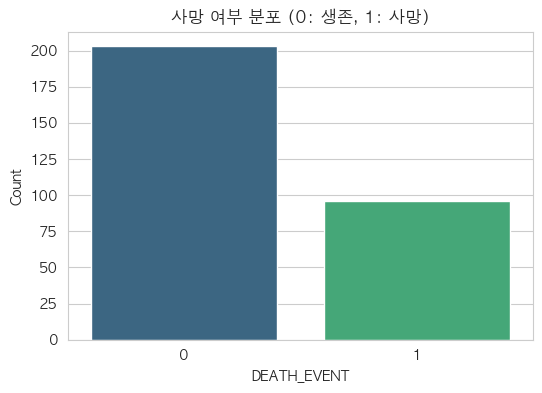

DEATH_EVENT
0    0.67893
1    0.32107
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='DEATH_EVENT', data=df, palette='viridis')
plt.title('사망 여부 분포 (0: 생존, 1: 사망)')
plt.xlabel('DEATH_EVENT')
plt.ylabel('Count')
plt.show()

print(df['DEATH_EVENT'].value_counts(normalize=True))

**인사이트**: 사망 데이터(1)가 생존 데이터(0)보다 적은 불균형(Imbalanced) 데이터셋입니다. 약 2:1의 비율을 보입니다.

### 4.2 주요 연속형 변수와 사망 여부의 관계

나이, 크레아틴 수치, 박출 계수 등이 사망에 미치는 영향을 확인합니다.

/var/folders/7l/yp5d25zx7nb_92wbp8w2b0dw0000gn/T/ipykernel_90099/1180682273.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DEATH_EVENT', y=col, data=df, ax=axes[i], palette='Set2')
/var/folders/7l/yp5d25zx7nb_92wbp8w2b0dw0000gn/T/ipykernel_90099/1180682273.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DEATH_EVENT', y=col, data=df, ax=axes[i], palette='Set2')
/var/folders/7l/yp5d25zx7nb_92wbp8w2b0dw0000gn/T/ipykernel_90099/1180682273.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DEATH_EVENT', y=col, data=df, ax=axes[

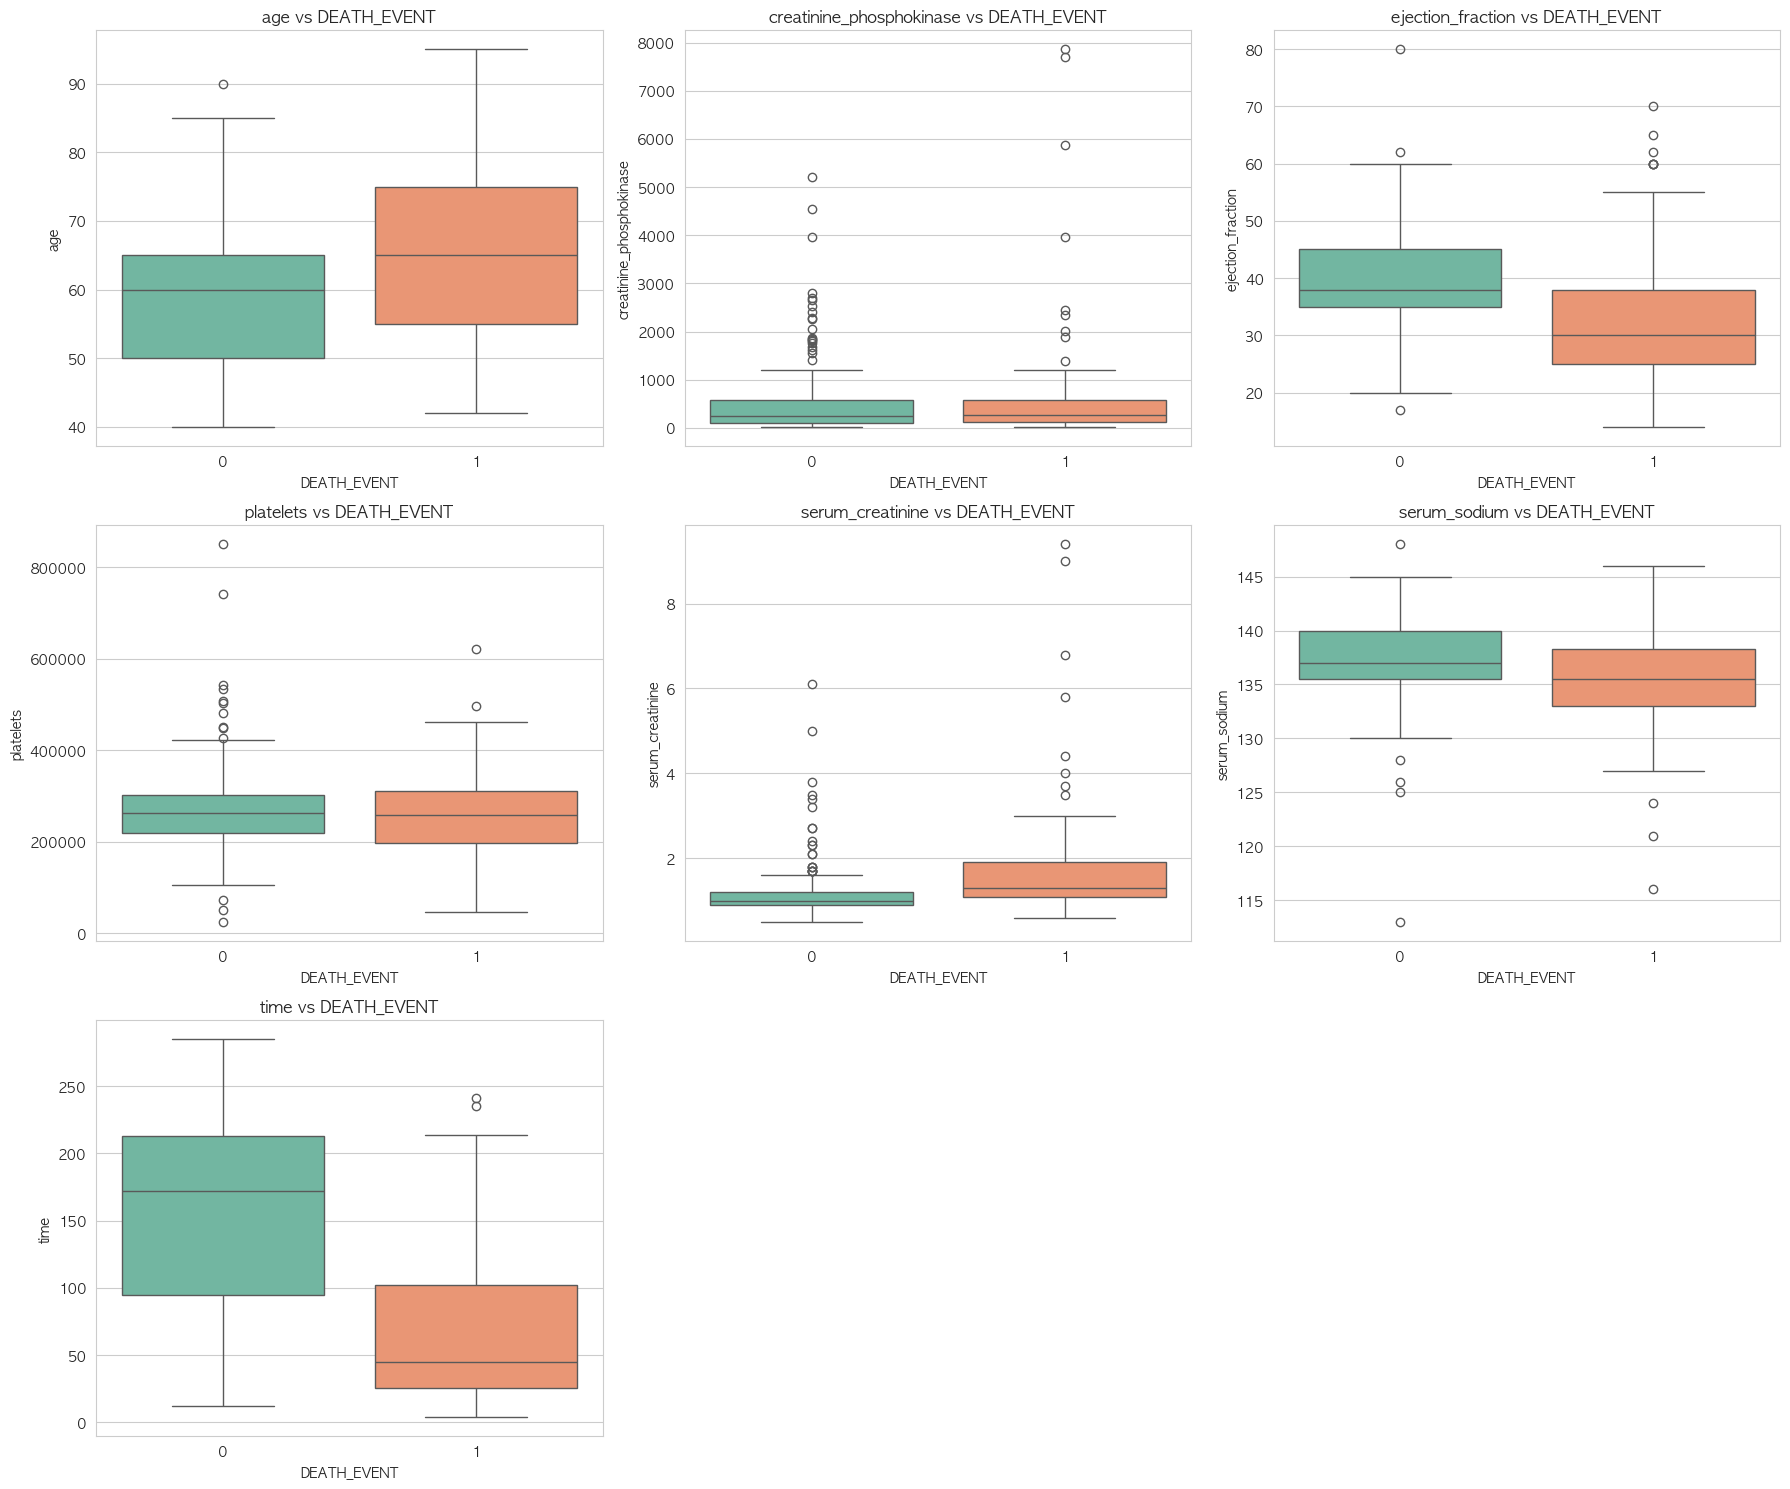

In [7]:
cols_continuous = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(cols_continuous):
    sns.boxplot(x='DEATH_EVENT', y=col, data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{col} vs DEATH_EVENT')

# 남은 subplot 정리
for j in range(len(cols_continuous), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 4.3 상관관계 분석

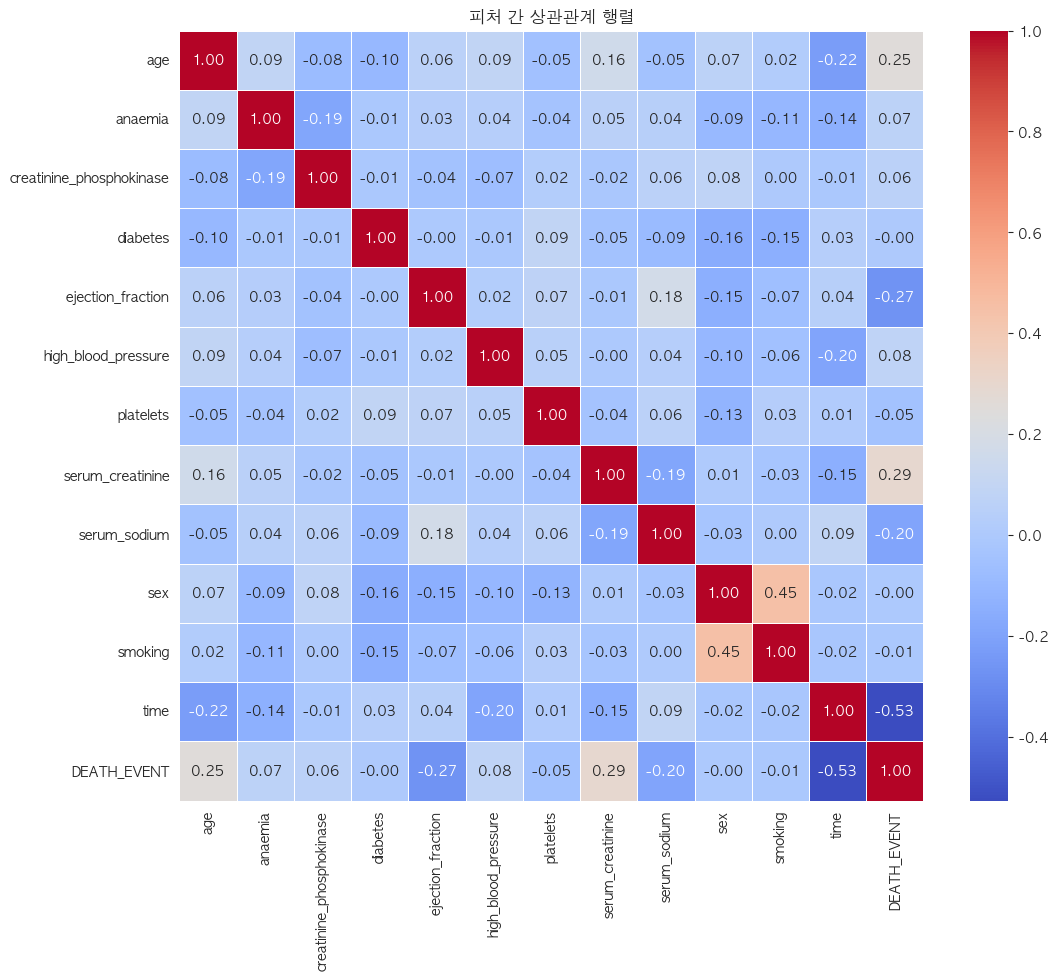

In [8]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('피처 간 상관관계 행렬')
plt.show()

**EDA 주요 발견점**:
1. **time**: 관찰 기간이 짧을수록 사망(1) 비중이 높습니다. 이는 조기 사망했기 때문일 수도 있고, 상태가 위중하여 관찰 기간이 짧았을 수도 있습니다. 가장 강력한 예측 인자가 될 가능성이 높습니다.
2. **ejection_fraction**: 박출계수가 낮을수록 사망 위험이 높은 경향이 보입니다.
3. **serum_creatinine**: 혈중 크레아틴 수치가 높을수록 사망 위험이 높습니다.
4. **age**: 나이가 많을수록 사망 위험이 다소 증가합니다.

## 5. Model: 모델링

데이터 전처리 후 Classification 모델을 학습합니다.

In [9]:
# Feature와 Target 분리
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

# Train/Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training Set:", X_train.shape)
print("Test Set:", X_test.shape)

Training Set: (239, 12)
Test Set: (60, 12)


In [10]:
# 모델 학습 및 평가 함수 정의
def train_and_evaluate(model, model_name):
    # 학습
    model.fit(X_train_scaled, y_train)
    
    # 예측
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # 평가
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return model

In [11]:
# 1. Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg = train_and_evaluate(log_reg, "Logistic Regression")

--- Logistic Regression ---
Accuracy: 0.8166666666666667
ROC AUC: 0.858793324775353

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.87        41
           1       0.79      0.58      0.67        19

    accuracy                           0.82        60
   macro avg       0.81      0.75      0.77        60
weighted avg       0.81      0.82      0.81        60



In [12]:
# 2. Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf = train_and_evaluate(rf_clf, "Random Forest")

--- Random Forest ---
Accuracy: 0.8333333333333334
ROC AUC: 0.8908857509627727

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.80      0.63      0.71        19

    accuracy                           0.83        60
   macro avg       0.82      0.78      0.79        60
weighted avg       0.83      0.83      0.83        60



## 6. Interpret: 해석 및 결론

모델이 중요하게 생각하는 Feature를 확인합니다.

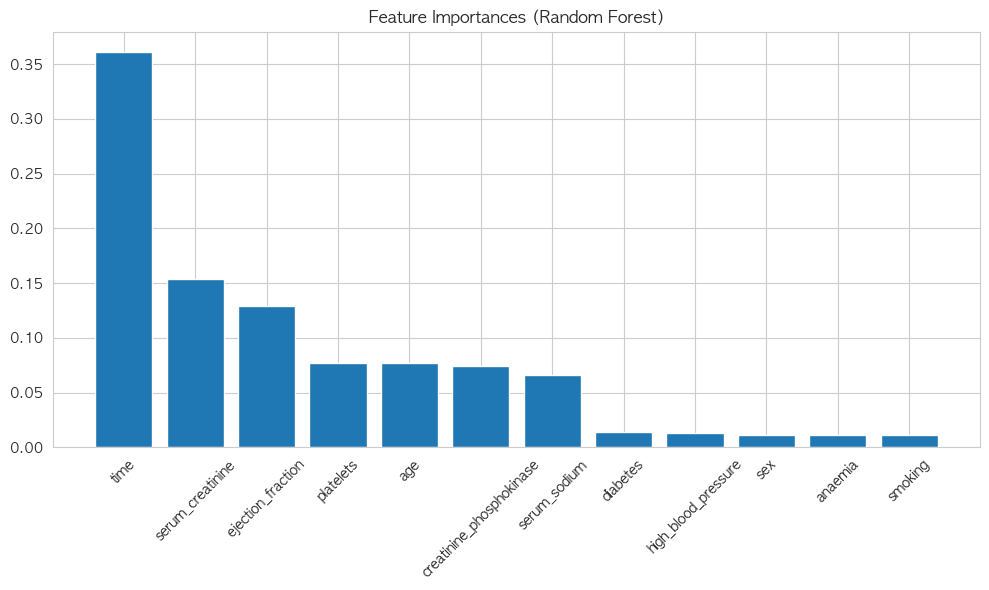

In [13]:
# Random Forest Feature Importance 시각화
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=45)
plt.tight_layout()
plt.show()

## 7. 결론

분석 결과, 심부전증 환자의 생존에 가장 큰 영향을 미치는 요인은 **관찰 기간(time)**, **혈중 크레아틴(serum_creatinine)**, **박출 계수(ejection_fraction)**, **나이(age)** 순으로 나타났습니다.
- **모델 성능**: Random Forest와 Logistic Regression 모두 준수한 성능을 보였으나, 데이터 특성에 따라 튜닝이 더 필요할 수 있습니다.
- **시사점**: 조기에 발견하여 크레아틴 수치를 관리하고 심장 기능을 보존하는 것이 생존율을 높이는 데 중요할 수 있음을 데이터가 시사합니다.